In [7]:
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [8]:
df = pd.read_csv('sbux.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [9]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [10]:
# Start by doing the WRONG thing = trying to predict the price itself
series = df['close'].values.reshape(-1,1)
series

array([[28.185],
       [28.07 ],
       [28.13 ],
       ...,
       [54.69 ],
       [55.61 ],
       [54.46 ]])

In [13]:
# Normalize the data
# Note: I didn't thing about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series)])
series = scaler.transform(series).flatten()
series

array([-1.94144714, -1.95251788, -1.94674184, ...,  0.61011874,
        0.6986847 ,  0.58797726])

In [15]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t: t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

In [16]:
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print(f"X.shape: {X.shape}, Y.shape: {Y.shape}, N.length: {N}")

X.shape: (1249, 10, 1), Y.shape: (1249,), N.length: 1249


In [17]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(lr=0.1), metrics=['accuracy'])

C:\Users\user\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
# train the RNN
r = model.fit(X[:-N//2], Y[:-N//2], epochs=100, validation_data=(X[-N//2:], Y[-N//2:]))

Epoch 1/100
20/20 [==============================] - 2s 21ms/step - loss: 0.1292 - accuracy: 0.0000e+00 - val_loss: 0.0573 - val_accuracy: 0.0000e+00
Epoch 2/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0063 - accuracy: 0.0000e+00 - val_loss: 0.0182 - val_accuracy: 0.0000e+00
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0037 - accuracy: 0.0000e+00 - val_loss: 0.0269 - val_accuracy: 0.0000e+00
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - val_loss: 0.0183 - val_accuracy: 0.0000e+00
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0030 - accuracy: 0.0000e+00 - val_loss: 0.0176 - val_accuracy: 0.0000e+00
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0031 - accuracy: 0.0000e+00 - val_loss: 0.0145 - val_accuracy: 0.0000e+00
Epoch 7/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - 

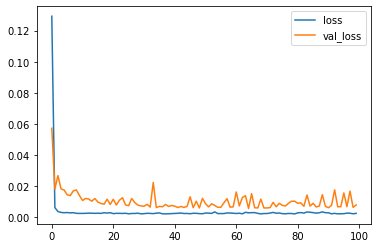

In [20]:
# plot accuracy per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [21]:
# One-step forecast using true targets
predicts = model.predict(X)
predicts.shape
final_predictions = predicts[:, 0]

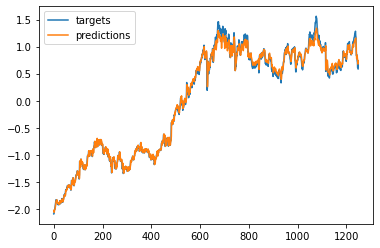

In [22]:
plt.plot(Y, label='targets')
plt.plot(final_predictions, label='predictions')
plt.legend()
plt.show()

In [23]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2]

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, T, 1))[0,0]
    validation_predictions.append(p)
    
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

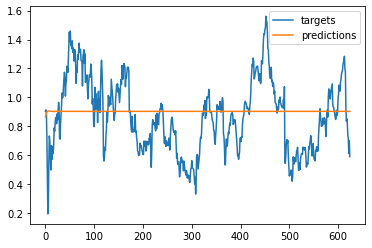

In [24]:
plt.plot(validation_target, label='targets')
plt.plot(validation_predictions, label='predictions')
plt.legend()
plt.show()

In [27]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1)

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [28]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [29]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df["Return"] = (df['close'] - df['PrevClose']) / df['PrevClose'] 

In [30]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


<AxesSubplot:>

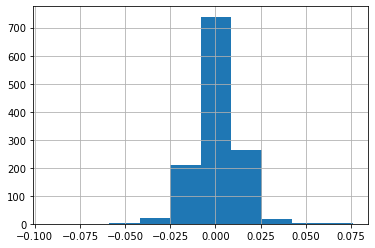

In [31]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [32]:
series = df['Return'].values[1:].reshape(-1, 1)
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series)])
series = scaler.transform(series).flatten()
series

array([-0.37879654,  0.12441548, -0.66715001, ..., -1.61585067,
        1.31287055, -1.72223474])

In [33]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t: t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print(f"X.shape: {X.shape}, Y.shape: {Y.shape}, N.length: {N}")

X.shape: (1248, 10, 1), Y.shape: (1248,), N.length: 1248


In [34]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(lr=0.1), metrics=['accuracy'])

# train the RNN
r = model.fit(X[:-N//2], Y[:-N//2], epochs=100, validation_data=(X[-N//2:], Y[-N//2:]))

Epoch 1/100


C:\Users\user\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 2s 22ms/step - loss: 0.9366 - accuracy: 0.0000e+00 - val_loss: 1.1103 - val_accuracy: 0.0000e+00
Epoch 2/100
20/20 [==============================] - 0s 6ms/step - loss: 0.9347 - accuracy: 0.0000e+00 - val_loss: 1.0751 - val_accuracy: 0.0000e+00
Epoch 3/100
20/20 [==============================] - 0s 6ms/step - loss: 0.9339 - accuracy: 0.0000e+00 - val_loss: 1.0804 - val_accuracy: 0.0000e+00
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 0.9342 - accuracy: 0.0000e+00 - val_loss: 1.1057 - val_accuracy: 0.0000e+00
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 0.9280 - accuracy: 0.0000e+00 - val_loss: 1.0893 - val_accuracy: 0.0000e+00
Epoch 6/100
20/20 [==============================] - 0s 6ms/step - loss: 0.9256 - accuracy: 0.0000e+00 - val_loss: 1.1066 - val_accuracy: 0.0000e+00
Epoch 7/100
20/20 [==============================] - 0s 6ms/step - loss: 0.9229 - accuracy: 0.0000e+00 - val_loss: 1.

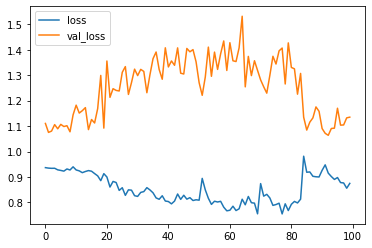

In [35]:
# plot accuracy per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

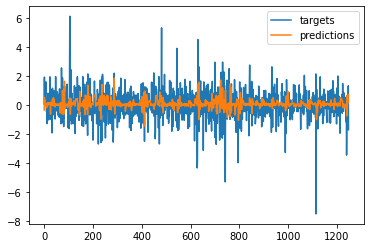

In [36]:
# One-step forecast using true targets
predicts = model.predict(X)
predicts.shape
final_predictions = predicts[:, 0]

plt.plot(Y, label='targets')
plt.plot(final_predictions, label='predictions')
plt.legend()
plt.show()

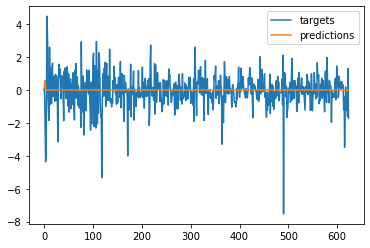

In [37]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2]

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, T, 1))[0,0]
    validation_predictions.append(p)
    
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

plt.plot(validation_target, label='targets')
plt.plot(validation_predictions, label='predictions')
plt.legend()
plt.show()

In [38]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [39]:
# Now make the actual data which will go into the nerual network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T

In [40]:
# normalize the inputs
Ntrain = len(input_data) * 2// 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T])
input_data = scaler.transform(input_data)

In [41]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [42]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N -Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N-Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [43]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

C:\Users\user\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [44]:
# train the RNN
r = model.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=300,
    validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 2s 21ms/step - loss: 0.6960 - accuracy: 0.4911 - val_loss: 0.6951 - val_accuracy: 0.4683
Epoch 2/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6971 - accuracy: 0.5054 - val_loss: 0.6970 - val_accuracy: 0.4878
Epoch 3/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6917 - accuracy: 0.5221 - val_loss: 0.6974 - val_accuracy: 0.4805
Epoch 4/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5364 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 5/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5209 - val_loss: 0.6925 - val_accuracy: 0.5171
Epoch 6/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6903 - accuracy: 0.5304 - val_loss: 0.6919 - val_accuracy: 0.5195
Epoch 7/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6898 - accuracy: 0.5232 - val_loss: 0.6966 - val_accuracy: 0.4927
Epoch 8/300


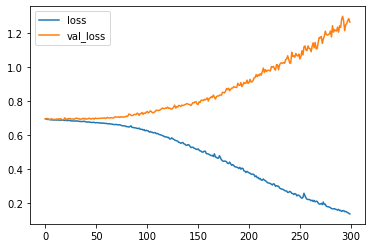

In [45]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

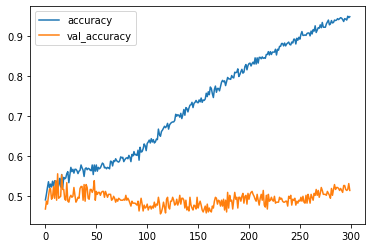

In [46]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()